In [128]:
import mne
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [129]:
n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

<Info | 8 non-empty values
 bads: []
 ch_names: F3, Fz, F4, C3, Cz, C4, P3, P4
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>

In [130]:
ga = 'datasets/Daniella Sehaber/Glucagon Ativo/OpenBCI-RAW-2023-10-26_12-43-47.txt'
gaOb = np.loadtxt(ga, delimiter=',', skiprows=5, usecols=range(1, 9))

basal = 'datasets/Daniella Sehaber/Glucagon Ativo/OpenBCI-RAW-2023-10-26_13-06-25.txt'
basalOb = np.loadtxt(ga, delimiter=',', skiprows=5, usecols=range(1, 9))

In [131]:
# Aula IA
gaIntervaloTempo = [
    "9:35 - 14:30",
]

# Basal (TF)
BasalIntervaloTempo = [
    "1:30 - 2:30"
]

In [132]:
import mne

def minutosParaSegundos(tempo):
    minutos, segundos = map(int, tempo.split(":"))
    return minutos * 60 + segundos

def converteIntervaloTempoParaIndice(intervaloTempo, sfreq):
    inicio, fim = map(str, intervaloTempo.split(" - "))
    novoInicio = minutosParaSegundos(inicio)
    novoFim = minutosParaSegundos(fim)
    
    indice = []
    indice.append(novoInicio * sfreq)
    indice.append(novoFim * sfreq)

    return indice

In [133]:
ga_index = []
ga_index = converteIntervaloTempoParaIndice(gaIntervaloTempo[0], 250)

basal_index = []
basal_index = converteIntervaloTempoParaIndice(BasalIntervaloTempo[0], 250)

recorteDadosGa = gaOb[ga_index[0]:ga_index[1], :]
recorteDadosBasal = basalOb[basal_index[0]:basal_index[1], :]

X = {
    'ga': mne.io.RawArray(recorteDadosGa.T, info),
    'basal': mne.io.RawArray(recorteDadosBasal.T, info),
}

Creating RawArray with float64 data, n_channels=8, n_times=73750
    Range : 0 ... 73749 =      0.000 ...   294.996 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.


In [134]:
from sklearn.preprocessing import StandardScaler
from scipy.signal import welch

# Aplicar filtros notch e passa-banda em cada segmento de dados
for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)

# Definir a frequência de amostragem (sfreq) se ainda não definida
sfreq = 250  # Exemplo, ajuste conforme necessário

# Calcular a Densidade Espectral de Potência (PSD) para os dados filtrados
freqs, psd_data = welch(X['basal']._data, sfreq, nperseg=1024)

# Normalizar os dados da PSD utilizando StandardScaler
scaler = StandardScaler()
data_basal_normalizada = scaler.fit_transform(psd_data)

# Atualizando o valor de X com os dados normalizados
#X['ga'] = data_normalizada


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband e

### Definição da janela deslizante

In [135]:
sr = 250            # Taxa de amostragem dos dados do EEG (250Hz)
jump = 5            # Tamanho da janela de análise (5 em 5 segundos)
size = sr * jump    # Número de pontos de dados em cada janela de análise

# Definindo os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz


samples = {
    'focus': [],
    'not_focus': []
}
total_pc = {}
data_names = ('ga',)

# Mapeamento de índices para rótulos
band_labels = {
    0: 'focus',
    1: 'not_focus',
}

for k, data in enumerate(X.values()): 
    results = [0, 0, 0, 0] # Contagem de dominância de cada banda
    labels = [] # Lista para armazenar os rótulos das janelas

    data.set_eeg_reference(ref_channels='average', projection=False)
    
    # Percorre os dados em incrementos de sr (1 segundo) extraindo janelas de tamanho size (4s)
    for i in range(0, int(data.times[-1] - jump), 1):
        tmin = i
        tmax = i + jump

        cut = data.copy().crop(tmin=tmin, tmax=tmax).get_data()

        # Número de pontos por segmento
        n_per_seg = 128
        # Quantidade de sobreposição entre segmentos
        n_overlap = n_per_seg // 2 # 64
        
        # Calculando a densidade espectral de potência (PSD)
        freqs, psd = welch(cut, fs=sr, nperseg=n_per_seg, noverlap=n_overlap)
        
        # realizando a média dos 8 eletrodos
        # transformando em um ndarray unidimensional
        X_avg = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        # Calculando a potência em cada banda de frequência por meio da integração da PSD
        bands = [
            np.sum(X_avg[theta_idxs]),
            np.sum(X_avg[alpha_idxs]),
            np.sum(X_avg[beta_idxs]),
            np.sum(X_avg[gamma_idxs])
        ]
        
        # Determina qual banda é a dominante (maior potência)
        dominant_band = np.argmax(bands)
        
        # Calculando a pontuação de cada banda para mostrar a porcentagem
        results[dominant_band] += 1
        
        if dominant_band == 2 or dominant_band == 3:
            samples['focus'].append(X_avg)
        else:
            samples['not_focus'].append(X_avg)

        # Adicionando o rótulo correspondente
        # labels.append(band_labels.get(dominant_band))

    # total = sum(results)
    # percentages = [round((count/total) * 100, 2) for count in results]
    # print(data.__str__())
    # total_pc[data_names[k]] = percentages

print(results)
# print(total_pc)
print(samples)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
[15, 0, 0, 39]
{'focus': [array([[4.22955487e-02, 4.27447351e-01, 1.62486379e+00, 1.02099109e+00,
        6.21199280e-01, 5.45529720e-01, 6.69911388e-01, 1.11957247e+00,
        1.03209240e+00, 1.34344671e+00, 1.27257857e+00, 6.91434308e-01,
        3.61313343e-01, 2.40764844e-01, 1.74209611e-01, 1.43617297e-01,
        1.10185867e-01, 7.65792331e-02, 7.10997126e-02, 8.90588144e-02,
        9.73807774e-02, 9.75235149e-02, 7.22472429e-02, 7.69475804e-02,
        7.78636447e-02, 8.14167547e-02, 8.49247039e-02, 7.77356310e-02,
        5.95358775e-02, 6.55631653e-02, 6.79891559e-02, 4.85034758e-02,
        4.97063986e-02, 4.31727674e-02, 4.16325193e-02, 3.35645529e-02,
        2.60472380e-02, 2.14617298e-02, 3.27403180e-02, 2.33063373e-02,
        3.63610483e-02, 5.12913965e-02, 3.00483535e-02, 1.56019084e-02,
        1.49113673e-02, 1.48993574e-02, 1.21794661e-02, 1.32811354e-02,

In [136]:
# Estimando o ruído de fundo (utilizando o sinal basal)

# média da potência no intervalo de tempo sem estímulo
base_power = np.average(data_basal_normalizada)
# média das médias de potência de todos os canais para estimar o ruído de fundo
estimated_background_noise = base_power
print(estimated_background_noise)


5.5402942359462e-17


In [137]:
# agora vamos adaptar ambas características 
# aplicando para o nosso sinal de interesse

# forçando (estragando) valor de "estimated_background_noise" para não sobrar valores negativos
lista = []
lista = samples['focus'] + samples['not_focus']
for data_focus in lista:
    target_amplitudes_adjusted = data_focus - estimated_background_noise

    # subtraindo o ruído de fundo das amplitudes
    narrow_band_SNR = 10 * np.log2(target_amplitudes_adjusted / estimated_background_noise)
    print(narrow_band_SNR)
    print(narrow_band_SNR.shape)

    total_power = np.sum(target_amplitudes_adjusted)
    wide_band_SNR = 10 * np.log10(target_amplitudes_adjusted / total_power)
    print(wide_band_SNR)
    print(wide_band_SNR.shape)


[[494.39464663 527.76633654 547.03133799 540.3278529  533.15943079
  531.28544716 534.24857198 541.6576293  540.48387152 544.28754114
  543.50569751 534.70479111 525.34137456 519.48511671 514.81711141
  512.03116431 508.20826106 502.95912039 501.88802554 505.13717232
  506.42595844 506.44708949 502.11901358 503.02834789 503.19908703
  503.84284542 504.45143109 503.17534851 499.32718153 500.71844334
  501.24263485 496.37046962 496.72390404 494.69080398 494.1666969
  491.05897252 487.40089225 484.60725187 490.70027159 485.79681122
  492.21352621 497.17675677 489.46244766 480.00681337 479.35371374
  479.34208936 476.43409719 477.68337308 477.50965273 478.17942946
  478.42212949 472.58756737 472.11589401 469.27196581 468.25269857
  466.49418456 461.26766775 453.0930721  442.25380529 434.67940883
  417.86524497 412.19121421 402.61576369 367.81554599 328.50147166]
 [482.97312727 516.17722255 536.19844568 529.42508001 525.45050008
  522.81743251 526.35006227 527.63378862 528.77300415 531.4549

[[-34.68929137 -23.77600411 -18.87404388 -19.8742325  -23.29478005
  -24.41705674 -23.6605742  -22.58242542 -20.53380549 -20.56106103
  -23.18724669 -25.29103459 -26.17658153 -29.33679462 -28.27627163
  -28.43521065 -29.35748668 -31.04135833 -31.1725632  -30.24987847
  -31.47024508 -31.30640418 -32.48496684 -32.97332925 -34.36584472
  -33.58842061 -33.3178622  -33.95239885 -33.60740327 -33.03527196
  -32.90027055 -34.7409789  -35.90660319 -34.32360138 -33.82656012
  -33.75664034 -35.16040333 -37.04464219 -36.08560554 -36.69284537
  -37.50171162 -35.92039476 -36.76802518 -37.77766308 -37.57164101
  -38.70498858 -38.09720007 -39.01276919 -39.50993453 -40.13139883
  -40.83077632 -42.37115681 -42.63063726 -42.90142939 -41.99737898
  -42.87341113 -44.59776075 -47.48626936 -49.62866136 -52.87517257
  -56.15916777 -58.25982362 -62.17635175 -73.74651154 -85.35751079]
 [-35.37674347 -24.80391723 -20.78450757 -22.27528506 -24.05473654
  -24.96106195 -27.39327113 -27.49375707 -24.31195082 -24.638

## Classificação de Dados EEG com SVM

Este código demonstra como preparar dados de EEG, treinar um classificador SVM (Support Vector Machine) e avaliar o desempenho do modelo. Abaixo está uma explicação detalhada de cada parte do código:

### 1. Preparação dos Dados

- **samples**: Um dicionário que contém duas listas de amostras de dados EEG:
  - `'focus'`: Amostras onde o cérebro está em estado de foco.
  - `'not_focus'`: Amostras onde o cérebro não está em estado de foco.

- **X**: Combina as amostras das duas condições (foco e não foco) em uma única matriz onde cada linha representa uma amostra.
- **y**: Vetor de rótulos correspondente a cada amostra em `X`. Aqui, `1` indica foco e `0` indica não foco.

### 2. Divisão dos Dados

- **train_test_split**: Função que divide os dados em conjuntos de treinamento e teste.
  - `X_train` e `y_train`: Dados e rótulos usados para treinar o modelo.
  - `X_test` e `y_test`: Dados e rótulos usados para avaliar o desempenho do modelo.
  - `test_size=0.2`: 20% dos dados são usados para teste, 80% para treinamento.
  - `random_state=42`: Define uma semente para garantir que a divisão dos dados seja reproduzível.

### 3. Criação e Treinamento do Modelo SVM

- **svm.SVC**: Cria um classificador SVM com um kernel linear.
- **clf.fit**: Treina o modelo com os dados de treinamento (`X_train` e `y_train`).

### 4. Avaliação do Modelo

- **clf.predict**: Faz previsões com base nos dados de teste (`X_test`).
- **classification_report**: Avalia o desempenho do modelo, fornecendo métricas como precisão, recall e F1-score para cada classe. As classes são rotuladas como `'Não Focado'` e `'Foco'`.

### Resultados Esperados

O relatório de classificação exibirá métricas de desempenho para o modelo, incluindo:
- **Precisão**: A proporção de previsões corretas entre as amostras previstas.
- **Recall**: A proporção de amostras corretas identificadas pelo modelo entre as amostras verdadeiras.
- **F1-Score**: A média harmônica entre precisão e recall, oferecendo uma única métrica de desempenho.

Este processo ajuda a avaliar a eficácia do modelo SVM na classificação de estados de foco e não foco com base nos dados de EEG.


In [138]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# `samples` é um dicionário com duas chaves: 'focus' e 'not_focus'
# Cada valor é uma lista de arrays, cada array é uma amostra da densidade espectral de potência (PSD)

# Convertendo o dicionário de amostras em arrays
X = np.vstack([samples['focus'], samples['not_focus']])
y = np.array([1] * len(samples['focus']) + [0] * len(samples['not_focus']))  # 1 para foco, 0 para não foco

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo SVM
clf = svm.SVC(kernel='linear') 
clf.fit(X_train, y_train)

# Fazer previsões
y_pred = clf.predict(X_test)

# Avaliar o modelo
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Não Focado', 'Foco']))

ValueError: Found array with dim 3. SVC expected <= 2.

## Relatório de Classificação Explicado

O relatório de classificação fornece métricas detalhadas sobre o desempenho do modelo SVM ao classificar os estados de foco e não foco com base nos dados de EEG. As métricas são apresentadas para cada classe (`Não Focado` e `Foco`), bem como médias gerais. Abaixo está uma explicação de cada métrica:

### Métricas para Cada Classe

1. **Não Focado**:
   - **Precisão (Precision)**: 0.88
     - A proporção de amostras corretamente classificadas como `Não Focado` entre todas as amostras classificadas como `Não Focado`. Significa que 88% das previsões de `Não Focado` são corretas.
   - **Recall**: 0.78
     - A proporção de amostras verdadeiramente `Não Focado` que foram corretamente identificadas pelo modelo. Significa que 78% das amostras `Não Focado` foram identificadas corretamente.
   - **F1-Score**: 0.82
     - A média harmônica entre precisão e recall, oferecendo uma métrica única que considera tanto a precisão quanto o recall. Um F1-Score de 0.82 indica um bom equilíbrio entre precisão e recall para a classe `Não Focado`.
   - **Support**: 9
     - O número de amostras reais da classe `Não Focado` no conjunto de teste.

2. **Foco**:
   - **Precisão (Precision)**: 0.97
     - A proporção de amostras corretamente classificadas como `Foco` entre todas as amostras classificadas como `Foco`. Significa que 97% das previsões de `Foco` são corretas.
   - **Recall**: 0.98
     - A proporção de amostras verdadeiramente `Foco` que foram corretamente identificadas pelo modelo. Significa que 98% das amostras `Foco` foram identificadas corretamente.
   - **F1-Score**: 0.98
     - A média harmônica entre precisão e recall para a classe `Foco`. Um F1-Score de 0.98 indica um excelente equilíbrio entre precisão e recall para a classe `Foco`.
   - **Support**: 66
     - O número de amostras reais da classe `Foco` no conjunto de teste.

### Métricas Gerais

- **Accuracy**: 0.96
  - A proporção total de previsões corretas (tanto `Foco` quanto `Não Focado`) entre todas as amostras no conjunto de teste. Um valor de 0.96 indica que o modelo acertou 96% das previsões.

- **Macro Avg (Média Macro)**:
  - **Precisão**: 0.92
    - A média das precisões de cada classe, sem considerar o suporte (tamanho das classes).
  - **Recall**: 0.88
    - A média dos recalls de cada classe, sem considerar o suporte.
  - **F1-Score**: 0.90
    - A média dos F1-Scores de cada classe, sem considerar o suporte.

- **Weighted Avg (Média Ponderada)**:
  - **Precisão**: 0.96
    - A precisão média ponderada pela proporção de amostras de cada classe.
  - **Recall**: 0.96
    - O recall médio ponderado pela proporção de amostras de cada classe.
  - **F1-Score**: 0.96
    - O F1-Score médio ponderado pela proporção de amostras de cada classe.

### Conclusão

O modelo SVM mostrou um desempenho muito bom na classificação de estados de foco e não foco. A precisão, recall e F1-Score são altos, especialmente para a classe `Foco`, indicando que o modelo é bastante eficaz na identificação de estados de foco. O relatório geral também mostra que o modelo tem uma alta precisão e recall em geral, com médias ponderadas e macro que confirmam a eficácia do modelo.


### Visualização da Eficácia do Modelo SVM
Para avaliar a eficácia do modelo de Support Vector Machine (SVM) que foi treinado para classificar estados de foco em EEG, criamos duas visualizações principais:

- Curva ROC: Esta curva ilustra o desempenho do modelo em diferentes limiares de decisão. A área sob a curva (AUC) é uma medida de quão bem o modelo consegue distinguir entre as classes. Um valor de AUC próximo de 1 indica um excelente desempenho, enquanto um valor próximo de 0.5 sugere que o modelo não tem habilidade discriminativa superior à aleatoriedade.

- Matriz de Confusão: A matriz de confusão fornece uma visão detalhada sobre o número de previsões corretas e incorretas feitas pelo modelo. Mostra a quantidade de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos, ajudando a identificar como o modelo se comporta em relação a cada classe específica.

As visualizações ajudam a entender não apenas a acurácia global do modelo, mas também como ele lida com cada classe individualmente e como seu desempenho varia com diferentes limiares.









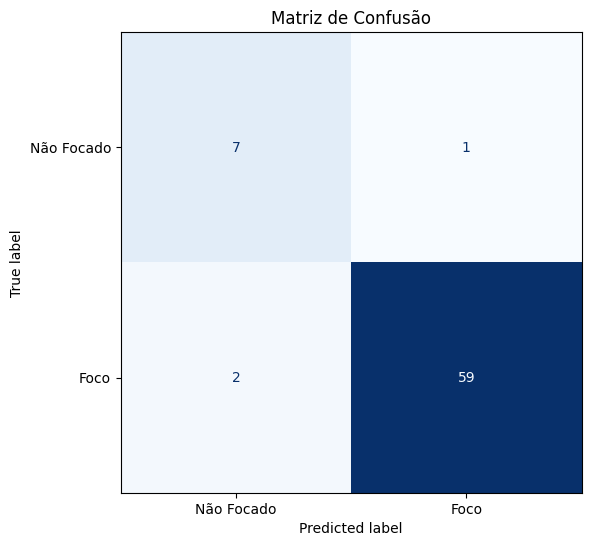

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Focado', 'Foco'])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()



### Definições dos Valores da Matriz

- **Verdadeiro Negativo (VN):** 7
  - Número de amostras que realmente são da classe "Não Focado" e foram corretamente classificadas como "Não Focado".

- **Falso Positivo (FP):** 2
  - Número de amostras que realmente são da classe "Não Focado" mas foram incorretamente classificadas como "Foco".

- **Falso Negativo (FN):** 1
  - Número de amostras que realmente são da classe "Foco" mas foram incorretamente classificadas como "Não Focado".

- **Verdadeiro Positivo (VP):** 65
  - Número de amostras que realmente são da classe "Foco" e foram corretamente classificadas como "Foco".

### Métricas de Desempenho

- **Precisão para "Não Focado":**

  A precisão para a classe "Não Focado" é 78%, o que indica que 78% das amostras classificadas como "Não Focado" são realmente da classe "Não Focado".

- **Precisão para "Foco":**

  A precisão para a classe "Foco" é 98%, o que indica que 98% das amostras classificadas como "Foco" são realmente da classe "Foco".

- **Recall para "Não Focado":**
- 
  O recall para a classe "Não Focado" é 88%, o que indica que 88% das amostras realmente "Não Focado" foram corretamente identificadas.

- **Recall para "Foco":**

  O recall para a classe "Foco" é 97%, o que indica que 97% das amostras realmente "Foco" foram corretamente identificadas.

### Conclusão

Com base nos resultados:

- O algoritmo SVM é muito eficaz na identificação dos períodos de "Foco", com uma alta precisão e recall para essa classe (98% e 97%, respectivamente).
- No entanto, o modelo é menos eficiente na identificação de períodos de "Não Focado", com uma precisão de 78% e recall de 88%. Isso sugere que o SVM tem mais dificuldades para classificar corretamente amostras da classe "Não Focado".

Esses resultados indicam que, embora o SVM seja excelente para detectar períodos de "Foco", pode ser necessário melhorar o desempenho na detecção de períodos de "Não Focado" para obter um equilíbrio melhor entre as classes.
